In [20]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 16, 'figure.figsize':(8,6)})

## Plotting functions

In [164]:
def plot_error(statistic, errtag):
    
    res_dir = '../../clust/results_{}/'.format(statistic)
    GP_error = np.loadtxt(res_dir+"{}_error{}.dat".format(statistic, errtag))

    rads = np.linspace(2, 24, 12)
    plt.plot(rads, GP_error)
    plt.figure()
    plt.semilogy(rads, GP_error)

In [252]:
def plot_training(statistic, traintag, errtag='', subsample=None, version=None):
    plt.figure()    
    ps = []
    nbins = 12

    fixed_cosmo = False
    fixed_hod = False
    if "hod" in traintag:
        fixed_hod = True
    elif "cos" in traintag:
        fixed_cosmo = True
    
    if fixed_hod:
        CC = range(0, 40)
        HH = range(0, 1)
        HH = np.atleast_2d(HH)
    elif fixed_cosmo:
        CC = range(0, 1)
        HH = range(0, 200)
        HH = np.atleast_2d(HH)
    else:
        CC = range(0, 40)
        #CC = range(0,1)
        HH = np.loadtxt("../CMASS/Gaussian_Process/GP/HOD_random_subsample_{}_version_{}.dat".format(subsample, version))
        #HH = np.atleast_2d(HH[0][:3])
    
    res_dir = '../../clust/results_{}/'.format(statistic)
    GP_error = np.loadtxt(res_dir+"{}_error{}.dat".format(statistic, errtag))
    print 'err:', GP_error
    
    color_idx = np.linspace(0, 1, np.max(HH)+1)

    for cosmo in CC:
        if fixed_hod or fixed_cosmo:
            HH_set = HH[0]
        else:
            HH_set = HH[cosmo]
        for hod in HH_set:
            hod = int(hod)
            color=plt.cm.rainbow(color_idx[hod])
            fn = '{}training_{}{}/{}_cosmo_{}_HOD_{}_test_0.dat'.format(res_dir, statistic, traintag, statistic, cosmo, hod)
            r, p = np.loadtxt(fn, delimiter=',',unpack=True)
            #plt.semilogy(n, p, marker='o')
            #plt.errorbar(n, p, yerr=pstd, fmt='o')
            plt.errorbar(r[:nbins], p[:nbins], yerr=GP_error[:nbins], lw=0.5, elinewidth=1, capsize=1, color=color)

    plt.yscale("log")
    plt.xlabel("r (Mpc/h)") #is it? are positions in Mpc? not h?
    plt.ylabel(r"P$_v$(r)")

In [254]:
def plot_accuracy(statistic, acctag, hod=None, subsample=None, version=None):
    ncols = 4
    fig, ax = plt.subplots(ncols, 1, figsize=(10,15), gridspec_kw={'height_ratios': [1]*ncols})

    nbins = 12

    fixed_cosmo = False
    fixed_hod = False
    if type(hod)==int:
        fixed_hod = True
    if "cos" in traintag:
        fixed_cosmo = True
    
    assert not fixed_hod or (fixed_hod and type(hod)==int), "if fixed_hod must specify hod"
    
    if fixed_hod:
        CC_test = range(0, 7)
        HH_test = range(hod, hod+1)
    elif fixed_cosmo:
        CC_test = range(0, 1)
        HH_test = range(0, 7)
    else:
        CC_test = range(0, 7)
        HH_test = range(0, 10)
        
    upf_mean = np.zeros(nbins)
    
    for cosmo in CC_test:
        for hod in HH_test:
            hod = int(hod)
            if "mean" in savetag:
                idtag = '{}_cosmo_{}_HOD_{}_mean'.format(statistic, cosmo, hod)
            else:
                idtag = '{}_cosmo_{}_Box_0_HOD_{}_test_0.dat'.format(statistic, cosmo, hod)
            fnt = '../testing_results/tests_{}{}/{}.dat'.format(statistic, acctag, idtag)
            ntest, ptest = np.loadtxt(fnt)
            upf_mean += ptest[:nbins]

    upf_mean /= len(CC_test)*len(HH_test)
    print "mean:",upf_mean    
    #color_idx = np.linspace(0, 1, len(CC_test)*len(HH_test))
    color_idx = np.linspace(0, 1, len(HH_test))

    i = 0
    for cosmo in CC_test:
        for hod in HH_test:
            hod = int(hod)
            color=plt.cm.rainbow(color_idx[hod])
            
            if "mean" in savetag:
                idtag = '{}_cosmo_{}_HOD_{}_mean'.format(statistic, cosmo, hod)
            else:
                idtag = '{}_cosmo_{}_Box_0_HOD_{}_test_0.dat'.format(statistic, cosmo, hod)
            fnt = '../testing_results/tests_{}{}/{}.dat'.format(statistic, acctag, idtag)
            
            ntest, ptest = np.loadtxt(fnt)
            if i==0:
                ax[0].semilogy(ntest[:nbins], ptest[:nbins], marker='o', ls='None', markerfacecolor='None', markeredgecolor=color, label='testbox (actual)')
            else:
                ax[0].semilogy(ntest[:nbins], ptest[:nbins], marker='o', ls='None', markerfacecolor='None', markeredgecolor=color)

            
            fnp = '../testing_results/predictions_{}{}/{}.dat'.format(statistic, acctag, idtag)
            npredic, ppredic = np.loadtxt(fnp)
            if i==0:
                ax[0].semilogy(npredic[:nbins], ppredic[:nbins], marker=None, ls='-', color=color, label='emulator prediction')
            else: 
                ax[0].semilogy(npredic[:nbins], ppredic[:nbins], marker=None, ls='-', color=color)
            ax[0].set_ylabel(r"P$_v$(r)")

            i += 1

            ax[1].plot(ntest[:nbins], ptest[:nbins]/upf_mean[:nbins], marker='o', ls='None', markerfacecolor='None', markeredgecolor=color)
            ax[1].plot(npredic[:nbins], ppredic[:nbins]/upf_mean[:nbins], marker=None, ls='-', color=color)
            ax[1].set_ylabel(r"P$_v$/P$_{v,mean}$")

            fracerr = (ppredic-ptest)/ptest
            ax[2].plot(ntest[:nbins], fracerr[:nbins], color=color)
            ax[2].set_ylabel(r"(P$_{emulator}$-P$_{true}$)/P$_{true}$")
            #ax1.plot(ntest, ppredic/ptest)

    frac_rms = np.loadtxt("../testing_results/{}_testing_results{}.dat".format(statistic, acctag))

    std = np.std(frac_rms, axis=0)
    var = np.var(frac_rms, axis=0)
    ax[3].semilogy(ntest[:nbins], var[:nbins], color='b', label='prediction error (var)')
    ax[3].semilogy(ntest[:nbins], std[:nbins], color='g', label='prediction error (std)')
    ax[3].semilogy(ntest[:nbins], GP_error[:nbins], color='r', label='training set error')
    ax[3].set_ylabel("fractional error")
    ax[3].legend()
                           
    plt.xlabel("r (Mpc/h)") #is it? are positions in Mpc? not h?
    ax[0].legend()


### Error

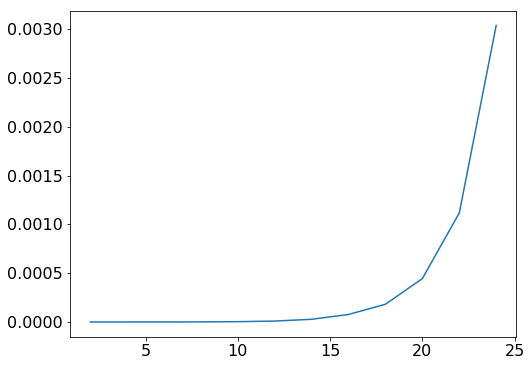

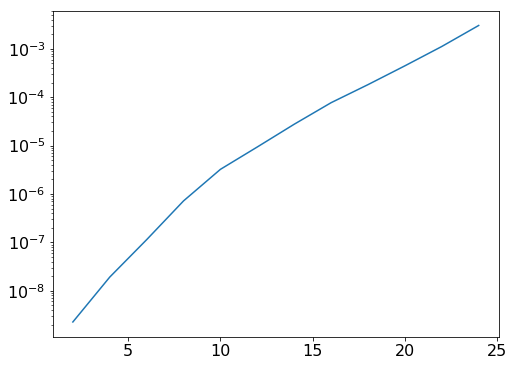

In [165]:
statistic = 'upf'
errtag = ''
plot_error(statistic, errtag)

### All (200 training HOD, 10 testing)

err: [2.25804078e-09 1.91224457e-08 1.13476511e-07 7.18247060e-07
 3.22801480e-06 9.36608897e-06 2.76303602e-05 7.70113173e-05
 1.81913961e-04 4.45166191e-04 1.11782194e-03 3.03920468e-03]


/Users/Kate/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:31: DeprecationWarning: object of type <type 'numpy.float64'> cannot be safely interpreted as an integer.


mean: [0.98793984 0.91984303 0.78346051 0.60250821 0.41554547 0.25597523
 0.14033093 0.0682546  0.02938608 0.01117302 0.00374265 0.0011035 ]


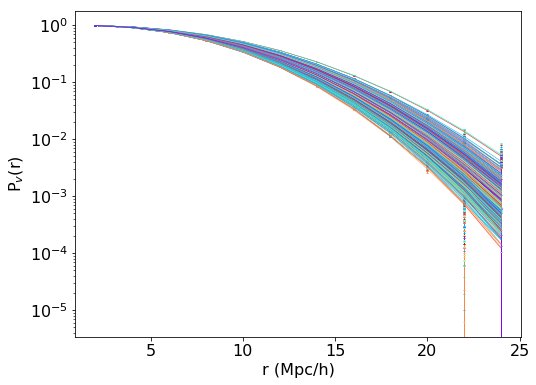

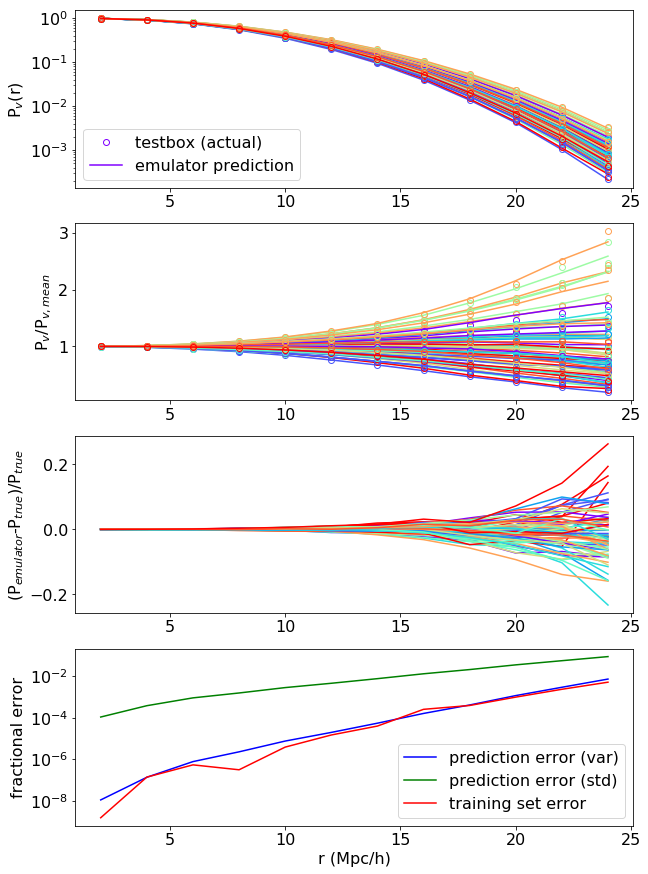

In [256]:
statistic='upf'
traintag = '_sample20'
testtag = '_all_mean'
errtag = ''
tag = ''
gptag = traintag + errtag + tag
acctag = gptag + testtag
plot_training(statistic, traintag, subsample=20, version=0)
plot_accuracy(statistic, acctag)

### Fixed cosmology (cosmo 0)

err: [2.25804078e-09 1.91224457e-08 1.13476511e-07 7.18247060e-07
 3.22801480e-06 9.36608897e-06 2.76303602e-05 7.70113173e-05
 1.81913961e-04 4.45166191e-04 1.11782194e-03 3.03920468e-03]
mean: [9.86744349e-01 9.12553817e-01 7.66102651e-01 5.75517920e-01
 3.83721417e-01 2.25833914e-01 1.16632166e-01 5.25887771e-02
 2.05228800e-02 6.92022286e-03 1.99473714e-03 4.91000000e-04]


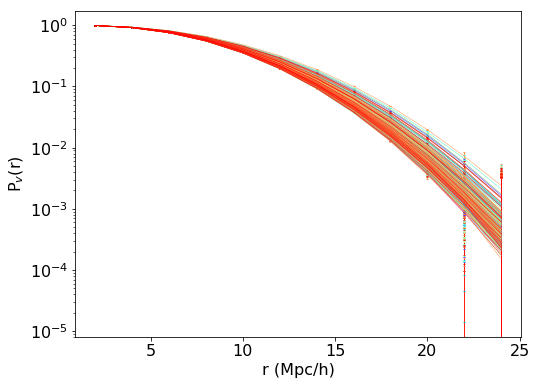

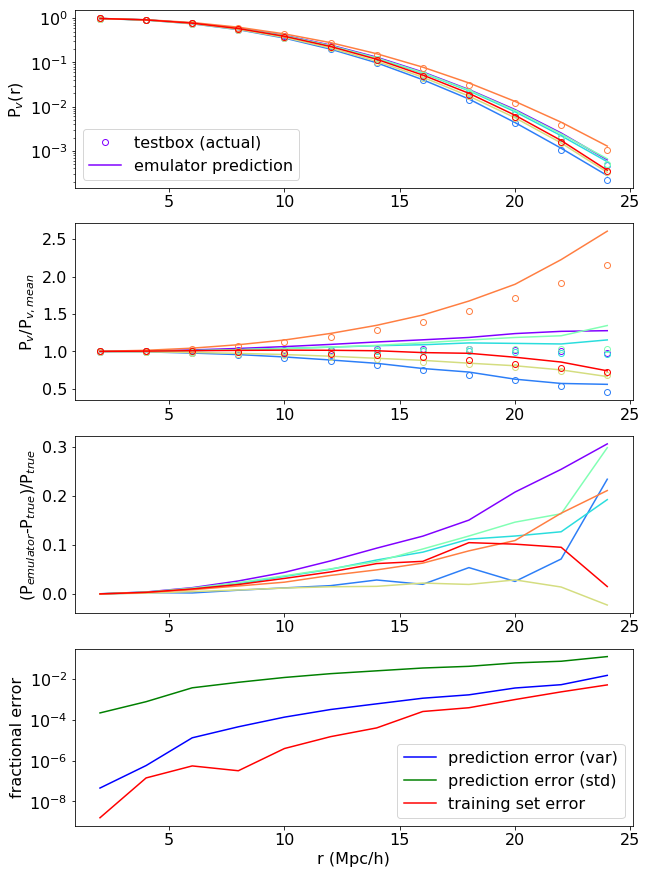

In [255]:
statistic='upf'
traintag = '_cos0'
testtag = '_cos0_mean'
errtag = ''
tag = ''
gptag = traintag + errtag + tag
acctag = gptag + testtag
plot_training(statistic, traintag)
plot_accuracy(statistic, acctag)

### Fixed HOD (hod 0)

mean: [0.98833635 0.9224055  0.78934426 0.61111574 0.42495303 0.26421237
 0.14617836 0.07171023 0.03107853 0.01185945 0.00396423 0.00115899]


NameError: global name 'sig2m' is not defined

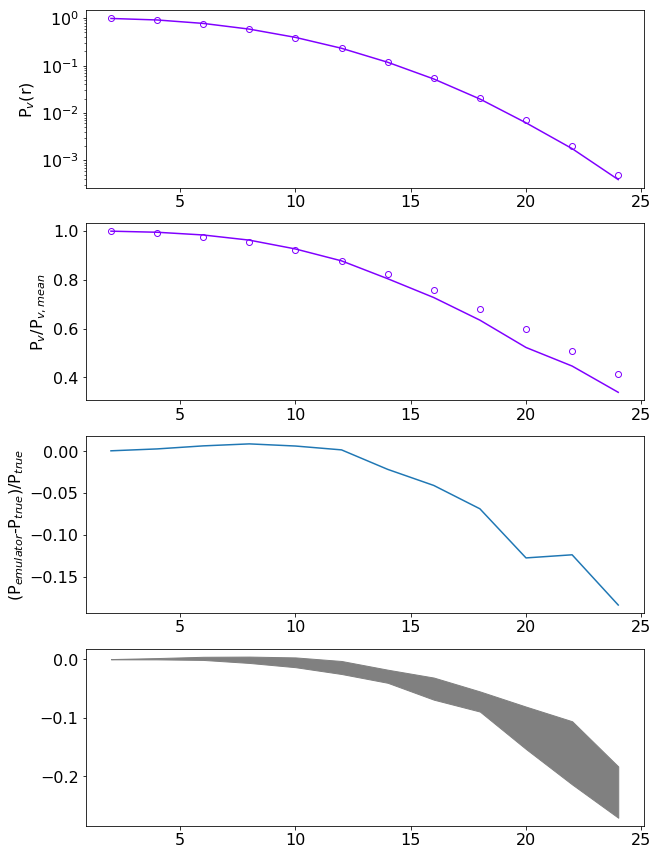

In [207]:
statistic = 'upf'
traintag = '_hod0'
testtag = '_hod0_mean'
errtag = ''
tag = ''
gptag = traintag + errtag + tag
acctag = gptag + testtag
plot_accuracy(statistic, acctag, hod=0)

### Fixed HOD (hod 1)

mean: [9.86531286e-01 9.10283400e-01 7.60199777e-01 5.66493469e-01
 3.74024320e-01 2.17775914e-01 1.11355543e-01 4.97549486e-02
 1.93310286e-02 6.50614286e-03 1.88737143e-03 4.70531429e-04]


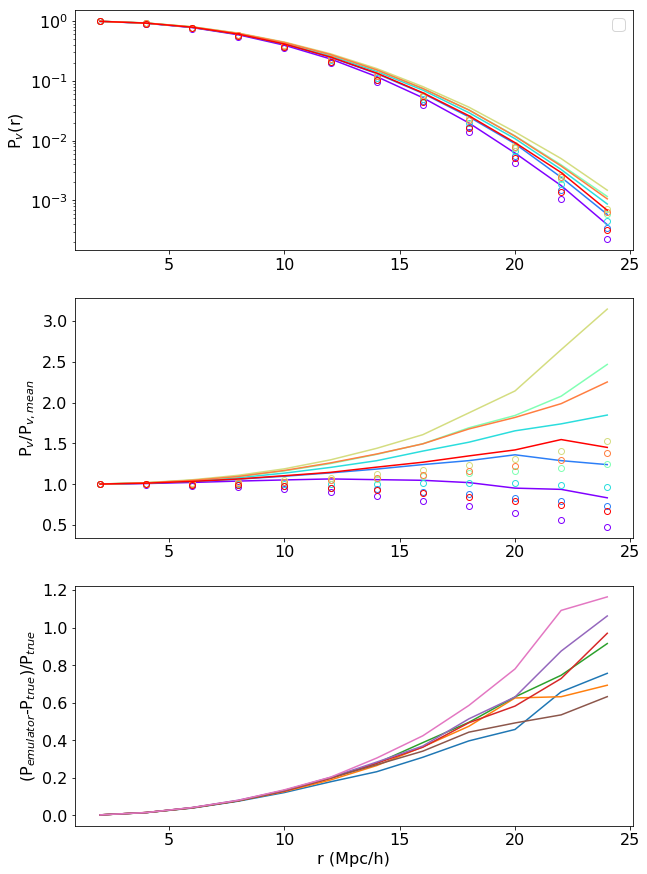

In [191]:
statistic = 'upf'
traintag = '_hod0'
testtag = '_hod1_mean'
errtag = ''
tag = ''
gptag = traintag + errtag + tag
acctag = gptag + testtag
plot_accuracy(statistic, acctag, hod=1)